<a href="https://colab.research.google.com/github/BaharehAm/Python-tutorials-for-Advanced-Data-Mining/blob/main/Tutorial_7_DNN%2C_RNN%2C_LSTM%2C_BiLSTM%2C_GRU%2C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%%capture
pip install yfinance

In [ ]:
import yfinance as yf
data = yf.download("AAPL", start="2021-01-01", end="2022-03-15")
len(data)
data
data.reset_index(inplace=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,127.680008,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.258591,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,124.907562,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.169830,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.284698,105158200
...,...,...,...,...,...,...,...
296,2022-03-08,158.820007,162.880005,155.800003,157.440002,156.492004,131148300
297,2022-03-09,161.479996,163.410004,159.410004,162.949997,161.968842,91454900
298,2022-03-10,160.199997,160.389999,155.979996,158.520004,157.565506,105342000
299,2022-03-11,158.929993,159.279999,154.500000,154.729996,153.798325,96970100


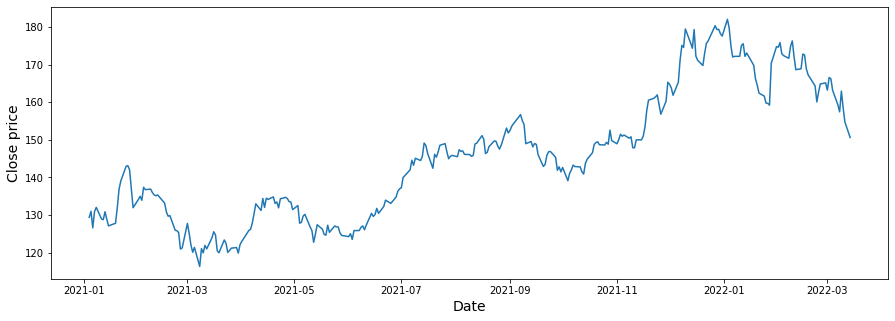

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data['Date'], data['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close price', fontsize=14)
plt.show()

In [ ]:
## Data scaling
from sklearn.preprocessing import MinMaxScaler
data_close = data[['Close']]
data_close
sc = MinMaxScaler(feature_range = (0, 1))
data_close_sc = sc.fit_transform(data_close)
data_close_sc
len(data_close_sc)

In [ ]:
def prepare_data(data, ratio, h):
  '''
   if you want to prepare data for hyper-prameter tuning, set ratio = 0.80, then, the test_size will be the size of your validation set
   after finding your optimal hyper-parameters, you need to call the prepare_data function once again for the purpose of model evaluation and you should set ratio = 1.0
   '''
  data_size = int(ratio * len(data))
  data = data[:data_size]

  train_size = int(len(data) * 0.80)
  test_size = len(data)-train_size
  ## prepare the training set for training the model
  train_set = data[:train_size]
  test_set = data[train_size : train_size + test_size]
  X_train = []
  y_train = []
  for i in range(h, train_size):
    X_train.append(train_set[i-h:i])                         ## Xt:(C_t-h, ... , C_t-1) ==> yt:C_t
    y_train.append(train_set[i])
  X_train, y_train = np.array(X_train), np.array(y_train)

  ## prepare the test set for making predictions
  temp = data[train_size-h : train_size + test_size]
  X_test = []
  for i in range(h, len(temp)):
    X_test.append(temp[i-h:i])
  X_test = np.array(X_test)
  y_test = np.array(test_set)
  return X_train, y_train, X_test, y_test, train_size, test_size


In [ ]:
h = 7
ratio = 1
input = prepare_data(data_close_sc,  ratio, h)

X_train = input[0]
y_train = input[1]
X_test = input[2]
y_test = input[3]

In [ ]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (233, 7, 1)
y_train:  (233, 1)
X_test:  (61, 7, 1)
y_test (61, 1)


## Keras [Sequential API](https://keras.io/api/models/sequential/)

The Sequential API is the simplest and most commonly used way to create a neural network in Keras. It allows you to create a model by simply adding layers to it one by one, in a linear fashion.

In [ ]:
%%capture
!pip install keras

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Bidirectional, GRU, Dense, Conv1D, MaxPooling1D, Flatten
from keras.utils.vis_utils import plot_model

### DNN

In [ ]:
X_train.shape

(233, 7, 1)

In [ ]:
## DNN model
DNN_model = Sequential()
DNN_model.add(Dense(units = 16, input_dim = X_train.shape[1], activation='relu'))
DNN_model.add(Dense(units = 8, activation='relu'))
DNN_model.add(Dense(units = 8, activation='relu'))
DNN_model.add(Dense(1, activation='linear'))

print(DNN_model.summary())

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_233 (Dense)           (None, 16)                128       
                                                                 
 dense_234 (Dense)           (None, 8)                 136       
                                                                 
 dense_235 (Dense)           (None, 8)                 72        
                                                                 
 dense_236 (Dense)           (None, 1)                 9         
                                                                 
Total params: 345
Trainable params: 345
Non-trainable params: 0
_________________________________________________________________
None


### RNN

The basic building block of an RNN is the recurrent cell, which is typically implemented using a simple neural network such as a single-layer feedforward network. The output of the recurrent cell is fed back into the input at the next time step, allowing the network to maintain a memory of previous inputs. One of the main advantages of RNNs is their ability to handle inputs of variable length, since the same weights are shared across all time steps. However, RNNs suffer from the problem of vanishing gradients, where the gradients used to update the weights become very small as they propagate backwards in time. This makes it difficult for the network to learn long-term dependencies and has led to the development of more advanced RNN architectures such as the LSTM and GRU.

In [ ]:
from IPython.display import Image
Image(url='https://editor.analyticsvidhya.com/uploads/86855simplilearn.gif')

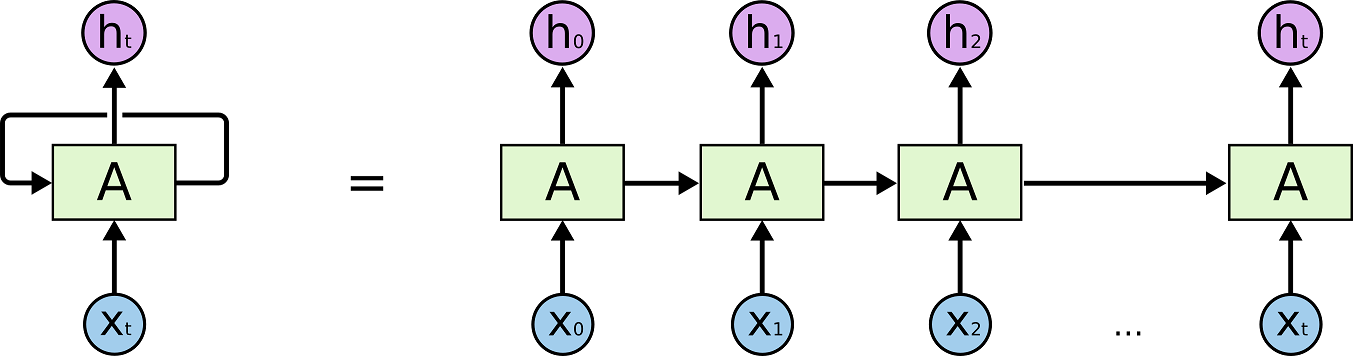
[Ref](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [ ]:
## RNN model
RNN_model = Sequential()
RNN_model.add(SimpleRNN(units = 16, activation='relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
RNN_model.add(SimpleRNN(units = 8, activation='relu'))
RNN_model.add(Dense(1, activation='linear'))

print(RNN_model.summary())

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 7, 16)             288       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_237 (Dense)           (None, 1)                 9         
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
None


### LSTM

The main idea behind LSTM is to use memory cells that can store information for a longer period of time, allowing the network to learn long-term dependencies. Each memory cell has three gates: an input gate, an output gate, and a forget gate. The input gate controls how much of the new input is added to the memory cell, the forget gate controls how much of the previous memory is retained, and the output gate controls how much of the memory is used to compute the output.

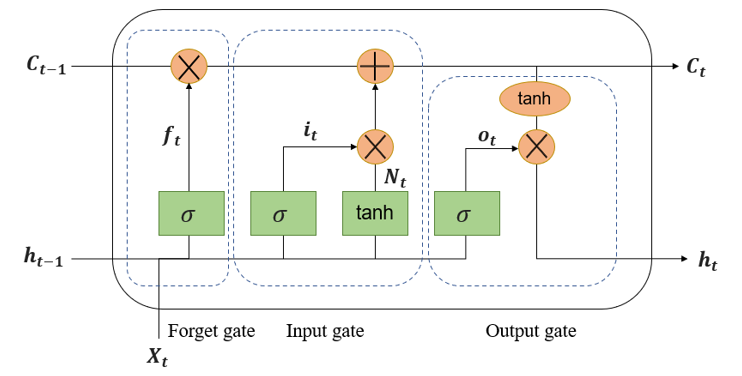

**Forget gate:** LSTM first decides whether information from the previous timestamp should be kept or not. This can be shown by Equation (1):

(1):  ` f_t = σ(X_t.U_f + H_(t-1).W_f )`							 	  	      

where X_t is input to the current timestamp, t, U_f is weight associated with the input, H_(t-1) is the hidden state of the previous timestamp, t-1, and W_f is the weight matrix associated with hidden state. A `sigmoid` function is applied to f_t and its value becomes 0 or 1. Value of 0 means that the network forgets everything and value of 1 indicates it will keep every information from t-1.

**Input gate:** this gate quantifies the importance of the new information that are entered the unit.

(2): `i_t = σ(X_t.U_i + H_(t-1).W_i )	`

U_i and W_i are the weight matrices associated with input and hidden states. Another `sigmoid` function is applied to i_t and its value will be between 0 and 1. The value that is close to 1 dedicates more importance to the input information. The new information that will be added or subtracted from the cell state of the LSTM is shown by Equation (3). This time a `tanh` activation function is used to make the input information between -1 for subtraction of information from cell state and 1 for adding information to the cell state. however, the new information, N_t, will be updated by input and forget gates before entering the cell state (Equation (4)).

(3): `N_t = tanh⁡(X_t.U_c + H_(t-1).W_c )`							 		      
(4): `C_t = f_t.C_(t-1) + i_t.N_t`

C_(t-1) is the cell state in the previous timestamp, t-1.

**Output gate:** this gate decides what information will be outputted as a hidden state at time t. This is determined by Equations (5) and (6).

(5): `O_t = σ(X_t.U_o + H_(t-1).W_o )`							 	 	      
(6): `h_t = O_t.tanh⁡(C_t )`							 		   	      


In [ ]:
## LSTM model
LSTM_model = Sequential()
LSTM_model.add(LSTM(units = 16, activation='relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
LSTM_model.add(LSTM(units = 8, activation='relu'))
LSTM_model.add(Dense(1, activation='linear'))

print(LSTM_model.summary())

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 7, 16)             1152      
                                                                 
 lstm_15 (LSTM)              (None, 8)                 800       
                                                                 
 dense_238 (Dense)           (None, 1)                 9         
                                                                 
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________
None


### Bidirectional LSTM (BiLSTM)

Bidirectional LSTM (BiLSTM) is an extension of the traditional LSTM architecture that allows the network to process input sequences in both forward and backward directions, thereby capturing the contextual information from both past and future.

In a traditional LSTM, the hidden state at each time step is only influenced by the previous time step. However, in a bidirectional LSTM, the hidden state is influenced by both the past and future context, allowing the model to better capture long-term dependencies in the input sequence.

The BiLSTM architecture consists of two separate LSTM layers, one processing the input sequence in the forward direction and the other in the backward direction. The outputs from both layers are concatenated and passed through a final layer to produce the final output.

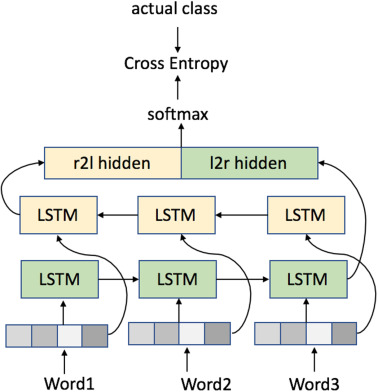

In [ ]:
## BiLSTM (Bidirectional LSTM) model
BiLSTM_model = Sequential()
BiLSTM_model.add(Bidirectional(LSTM(units = 16, activation='relu', return_sequences = True),  input_shape = (X_train.shape[1], X_train.shape[2])))
BiLSTM_model.add(Bidirectional(LSTM(units = 8, activation='relu')))
BiLSTM_model.add(Dense(1, activation='linear'))

print(BiLSTM_model.summary())

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 7, 32)            2304      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_239 (Dense)           (None, 1)                 17        
                                                                 
Total params: 4,945
Trainable params: 4,945
Non-trainable params: 0
_________________________________________________________________
None


### GRU

The key difference between the GRU and the LSTM is that the GRU has only two gates: the reset gate and the update gate. The reset gate determines how much of the past information should be forgotten, while the update gate controls how much of the new information should be retained.

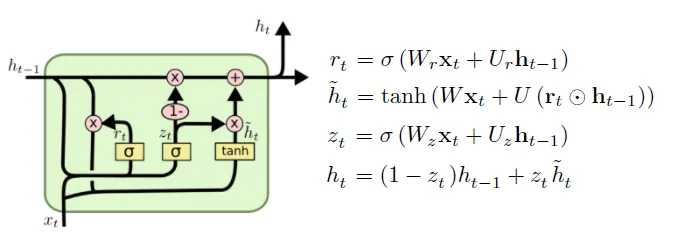
[Ref](https://sh-tsang.medium.com/review-empirical-evaluation-of-gated-recurrent-neural-networks-on-sequence-modeling-gru-2adb86559257)

In [ ]:
## GRU model
GRU_model = Sequential()
GRU_model.add(GRU(units = 16, activation='relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
GRU_model.add(GRU(units = 8, activation='relu'))
GRU_model.add(Dense(1, activation='linear'))

print(GRU_model.summary())

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 7, 16)             912       
                                                                 
 gru_7 (GRU)                 (None, 8)                 624       
                                                                 
 dense_240 (Dense)           (None, 1)                 9         
                                                                 
Total params: 1,545
Trainable params: 1,545
Non-trainable params: 0
_________________________________________________________________
None


### CNN

Figure below shows a simple 1-D CNN architecture. The input layer passes a fixed-length sequence from the full time series to the convolution layer. In our case, the input layer is fed with a sequence of h time steps from the Closing price series. The convolution layer slides one or multiple filters with the size of k over the input sequence one step at a time where k < h. From the mathematical point of view, a 1-D convolution operation is the inner product of two vectors: a subsequence from the input sequence (X) with length of k, and the filter:




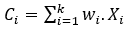

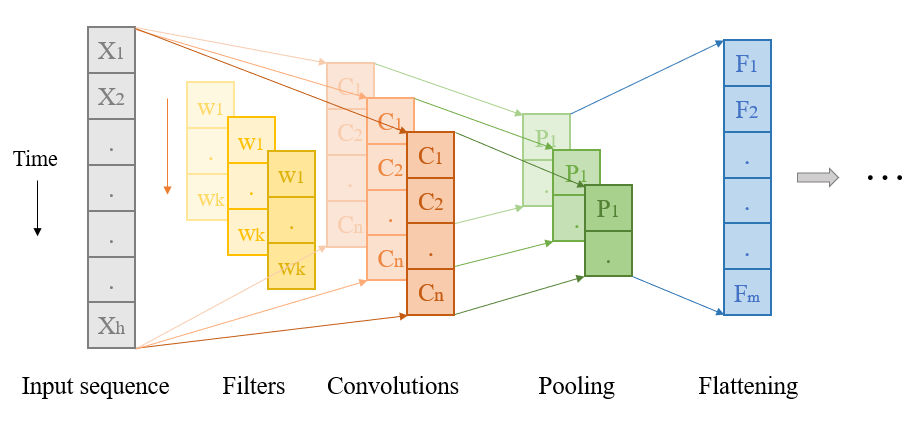

Consequently, the length of the output vectors (shown by n in the figure) is not equal to the length of the input sequence. The resulting vectors are somehow the smoothed version of the input sequence that include the most important features and information from that sequence.
An activation function is applied after the convolution to produce the output (not shown in the figure). The pooling layer comes after that and it combines the output of the previous layer at certain locations into a single neuron by taking the mean, maximum, or minimum of all values of those positions.

Finally, the outputs from the pooling operation are flattened to create a unique vector that can be followed by other layers such as a Dense layer to produce predictions.  

In [ ]:
## CNN model
CNN_model = Sequential()
CNN_model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(8, activation='relu'))
CNN_model.add(Dense(1, activation='linear'))

print(CNN_model.summary())

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5, 16)             64        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 16)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 dense_241 (Dense)           (None, 8)                 264       
                                                                 
 dense_242 (Dense)           (None, 1)                 9         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_______________________________________________________

## Training/evaluating all models (no hyper-parameter tuning)

**Compiling** refers to the process of configuring the learning process before training the model.

When you compile a neural network model, you specify several important parameters such as the `optimizer`, the `loss` function, and the `metrics` that you want to use to evaluate the performance of the model during training and testing.

The `optimizer` is the algorithm that is used to update the weights and biases of the neural network during training, while the `loss` function is used to measure how well the model is performing on the training data. The `metrics` are used to measure the performance of the model during training and evaluation.

In [ ]:
# Compiling
DNN_model.compile(optimizer = 'adam', loss = 'mse', metrics = 'RootMeanSquaredError')
RNN_model.compile(optimizer = 'adam', loss = 'mse', metrics = 'RootMeanSquaredError')
LSTM_model.compile(optimizer = 'adam', loss = 'mse', metrics = 'RootMeanSquaredError')
BiLSTM_model.compile(optimizer = 'adam', loss = 'mse', metrics = 'RootMeanSquaredError')
GRU_model.compile(optimizer = 'adam', loss = 'mse', metrics = 'RootMeanSquaredError')
CNN_model.compile(optimizer = 'adam', loss = 'mse', metrics = 'RootMeanSquaredError')

## Note that when we use the models for the classification case, we set loss='binary_crossentropy', metrics='accuracy'

`epoch`: one single pass through all the rows in the training dataset

`batch_size`: number of samples considered by the model before updating the weights.

In [ ]:
# Fitting models to the Training set
DNN_model_fit = DNN_model.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose=1, validation_data=(X_test, y_test))
RNN_model_fit = RNN_model.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose=0, validation_data=(X_test, y_test))
LSTM_model_fit = LSTM_model.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose=0, validation_data=(X_test, y_test))
BiLSTM_model_fit = LSTM_model.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose=0, validation_data=(X_test, y_test))
GRU_model_fit = GRU_model.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose=0, validation_data=(X_test, y_test))
CNN_model_fit = CNN_model.fit(X_train, y_train, epochs= 10, verbose=0, validation_data=(X_test, y_test))

Epoch 1/10
8/8 [==============================] - 2s 41ms/step - loss: 0.0539 - root_mean_squared_error: 0.2322 - val_loss: 0.1441 - val_root_mean_squared_error: 0.3797
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0298 - root_mean_squared_error: 0.1726 - val_loss: 0.0722 - val_root_mean_squared_error: 0.2688
Epoch 3/10
8/8 [==============================] - 0s 15ms/step - loss: 0.0135 - root_mean_squared_error: 0.1164 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1640
Epoch 4/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 5/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 6/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0075 - val_root_mean_squared_

In [ ]:
round(DNN_model.evaluate(X_test, y_test)[1], 4)

2/2 [==============================] - 0s 14ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829


0.0829

In [ ]:
DNN_model_fit.history['loss']

[0.053910426795482635,
 0.029803747311234474,
 0.01354891899973154,
 0.00677509093657136,
 0.006370690185576677,
 0.006529653910547495,
 0.0056710136123001575,
 0.005032957531511784,
 0.004539033398032188,
 0.003899295348674059]

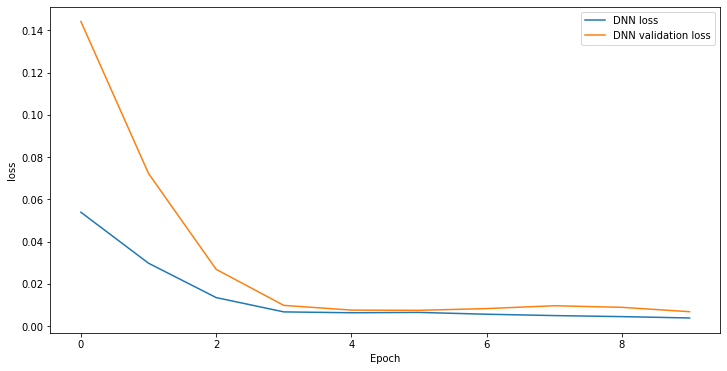

In [ ]:
## loss plots
histories = {
              'DNN': DNN_model_fit.history,
              # 'RNN': RNN_model_fit.history,
              # 'LSTM': LSTM_model_fit.history,
              # 'BiLSTM': BiLSTM_model_fit.history,
              # 'GRU': GRU_model_fit.history,
              # 'CNN': CNN_model_fit.history
             }
plt.figure(figsize=(12,6))
for key, value in histories.items():
  plt.plot(histories[key]['loss'], label =  key + ' loss')
  plt.plot(histories[key]['val_loss'], label =  key + ' validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
## make predictions
DNN_predictions = DNN_model.predict(X_test)
RNN_predictions = RNN_model.predict(X_test)
LSTM_predictions = LSTM_model.predict(X_test)
BiLSTM_predictions = BiLSTM_model.predict(X_test)
GRU_predictions = GRU_model.predict(X_test)
CNN_predictions = CNN_model.predict(X_test)
print("predicted values shapes: " , DNN_predictions.shape, RNN_predictions.shape, LSTM_predictions.shape, BiLSTM_predictions.shape, GRU_predictions.shape, CNN_predictions.shape)

2/2 [==============================] - 0s 6ms/step
predicted values shapes:  (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)


In [ ]:
# Performance metrics: RMSE and MAE

from sklearn.metrics import mean_squared_error, mean_absolute_error

Pred_performance = [
                      ['DNN', np.sqrt(mean_squared_error(y_test, DNN_predictions)) , mean_absolute_error(y_test, DNN_predictions)],
                      ['RNN', np.sqrt(mean_squared_error(y_test, RNN_predictions)) , mean_absolute_error(y_test, RNN_predictions)],
                      ['LSTM', np.sqrt(mean_squared_error(y_test, LSTM_predictions)) , mean_absolute_error(y_test, LSTM_predictions)],
                      ['BiLSTM', np.sqrt(mean_squared_error(y_test, BiLSTM_predictions)) , mean_absolute_error(y_test, BiLSTM_predictions)],
                      ['GRU', np.sqrt(mean_squared_error(y_test, GRU_predictions)) , mean_absolute_error(y_test, GRU_predictions)],
                      ['CNN', np.sqrt(mean_squared_error(y_test, CNN_predictions)) , mean_absolute_error(y_test, CNN_predictions)]
                   ]

Pred_performance_df = pd.DataFrame(Pred_performance, columns = ['Model', 'RMSE', 'MAE'])
Pred_performance_df

,Model,RMSE,MAE
0,DNN,0.082863,0.064538
1,RNN,0.580199,0.572461
2,LSTM,0.297240,0.273483
3,BiLSTM,0.840341,0.833273
4,GRU,0.192740,0.177293
5,CNN,0.148482,0.125023


In [ ]:
DNN_predictions

array([[0.8329764 ],
       [0.8535684 ],
       [0.8683284 ],
       [0.837316  ],
       [0.82832676],
       [0.8195481 ],
       [0.81857103],
       [0.81364006],
       [0.8202099 ],
       [0.8495979 ],
       [0.8617901 ],
       [0.8843387 ],
       [0.89050186],
       [0.8968844 ],
       [0.90596527],
       [0.8894747 ],
       [0.87336105],
       [0.8641611 ],
       [0.85001177],
       [0.82815653],
       [0.82343453],
       [0.8186597 ],
       [0.8153228 ],
       [0.8214794 ],
       [0.80217415],
       [0.7766563 ],
       [0.75240946],
       [0.7237188 ],
       [0.6956685 ],
       [0.67077523],
       [0.65674347],
       [0.65126306],
       [0.6882998 ],
       [0.6981409 ],
       [0.7241638 ],
       [0.78346395],
       [0.81038386],
       [0.8256169 ],
       [0.82219243],
       [0.82758695],
       [0.8220399 ],
       [0.8080545 ],
       [0.8035309 ],
       [0.8050286 ],
       [0.8007675 ],
       [0.78166455],
       [0.7704261 ],
       [0.768

In [ ]:
## inverse predicted values to the original scale
DNN_predictions = sc.inverse_transform(DNN_predictions)
RNN_predictions = sc.inverse_transform(RNN_predictions)
LSTM_predictions = sc.inverse_transform(LSTM_predictions)
BiLSTM_predictions = sc.inverse_transform(BiLSTM_predictions)
GRU_predictions = sc.inverse_transform(GRU_predictions)
CNN_predictions = sc.inverse_transform(CNN_predictions)

In [ ]:
DNN_predictions

array([[171.04489],
       [172.39676],
       [173.36575],
       [171.32979],
       [170.73964],
       [170.16333],
       [170.09918],
       [169.77547],
       [170.20677],
       [172.1361 ],
       [172.93652],
       [174.41682],
       [174.82144],
       [175.24046],
       [175.83662],
       [174.754  ],
       [173.69615],
       [173.09216],
       [172.16327],
       [170.72847],
       [170.41847],
       [170.10501],
       [169.88594],
       [170.29012],
       [169.02272],
       [167.34749],
       [165.75568],
       [163.87215],
       [162.03062],
       [160.3964 ],
       [159.4752 ],
       [159.11542],
       [161.54689],
       [162.19295],
       [163.90135],
       [167.7944 ],
       [169.56169],
       [170.56174],
       [170.33693],
       [170.69107],
       [170.3269 ],
       [169.40877],
       [169.1118 ],
       [169.21013],
       [168.93037],
       [167.67627],
       [166.93846],
       [166.81705],
       [165.34651],
       [163.31873],


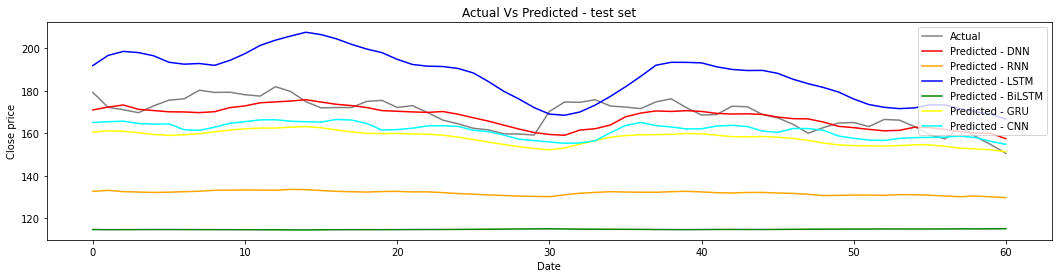

In [ ]:
# Visualising the results
train_size = input[4]
test_size = input[5]

plt.figure(figsize=(18,4))
plt.plot( data['Close'][train_size:train_size+test_size].values, color = 'gray', label = 'Actual')
plt.plot( DNN_predictions, color = 'red', label = 'Predicted - DNN')
plt.plot( RNN_predictions, color = 'orange', label = 'Predicted - RNN')
plt.plot( LSTM_predictions, color = 'blue', label = 'Predicted - LSTM')
plt.plot( BiLSTM_predictions, color = 'green', label = 'Predicted - BiLSTM')
plt.plot( GRU_predictions, color = 'yellow', label = 'Predicted - GRU')
plt.plot( CNN_predictions, color = 'cyan', label = 'Predicted - CNN')

plt.xticks(np.arange(0, test_size, 10))
plt.title('Actual Vs Predicted - test set')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend()
plt.show()

## Using functions + hyperparameter tuning

In [ ]:
def create_model(model_name, X_train, y_train, units1, units2, activation, filters, kernel_size, pool_size ):
  '''
  In this function, we assumed that all models have one hidden layers.
  Other number of hidden layers can be used to get more simpler or complex structures.
  '''
  model = Sequential()
  if model_name == 'DNN':
    model.add(Dense(units = units1, input_dim = X_train.shape[1], activation = activation))
    model.add(Dense(units = units2, activation = activation))
    model.add(Dense(1, activation = 'linear'))
  elif model_name == 'RNN':
    model.add(SimpleRNN(units = units1, input_shape = (X_train.shape[1], X_train.shape[2]), activation = activation, return_sequences = True))
    model.add(SimpleRNN(units = units2, activation = activation))
    model.add(Dense(1, activation = 'linear'))
  elif model_name == 'LSTM':
    model.add(LSTM(units = units1, input_shape = (X_train.shape[1], X_train.shape[2]), activation = activation, return_sequences = True))
    model.add(LSTM(units = units2, activation = activation))
    model.add(Dense(1, activation = 'linear'))
  elif model_name == 'BiLSTM':
    model.add(Bidirectional(LSTM(units = units1) , activation = activation, return_sequences = True), input_shape = (X_train.shape[1], X_train.shape[2]))
    model.add(Bidirectional(LSTM(units = units2, activation = activation)))
    model.add(Dense(1, activation = 'linear'))
  elif model_name == 'GRU':
    model.add(GRU(units = units1, input_shape = (X_train.shape[1], X_train.shape[2]), activation = activation, return_sequences = True))
    model.add(GRU(units = units2, activation = activation))
    model.add(Dense(1, activation = 'linear'))
  else: ## CNN model
    model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = activation, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size = pool_size))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))

  model_plot = plot_model(model, show_shapes=True, show_layer_names=True)

  return model, model_plot

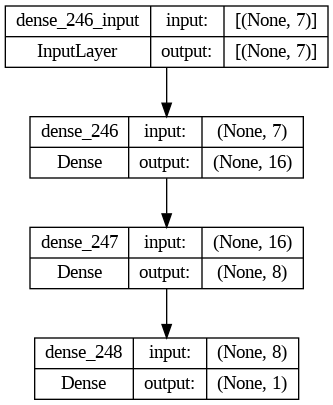

In [ ]:
plot_ = create_model('DNN', X_train, y_train, 16, 8, 'relu', 32, 3, 2)[1]
plot_

In [ ]:
def evaluate(model, X_train, y_train, X_test, y_test, optimizer, loss, epochs, batch_size ):
  model.compile(optimizer = optimizer, loss = loss, metrics = ['RootMeanSquaredError', 'MAE'])
  model_fit = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose=0, validation_data=(X_test, y_test))
  predictions_sc = model.predict(X_test)
  # RMSE = round(model.evaluate(X_test, y_test)[1], 4)[1]
  # MAE = round(model.evaluate(X_test, y_test)[2], 4)[2]
  RMSE = round(np.sqrt(mean_squared_error(y_test, predictions_sc)), 4)
  MAE = round(mean_absolute_error(y_test, predictions_sc) , 4)
  predictions = sc.inverse_transform(predictions_sc)
  return RMSE, MAE, predictions, model_fit

In [ ]:
## hyper-parameter tuning for DNN (we can do the same for the other models)

## Prepare inputs for validating the model
h = 7
ratio = 0.8
input = prepare_data(data_close_sc,  ratio, h)
X_train = input[0]
y_train = input[1]
X_test = input[2]
y_test = input[3]
train_size = input[4]
test_size = input[5]
print("train_size: %.F, test_size: %.F" %(train_size, test_size))

## hyper-parameters to be tuned
units1_set = [64, 32]
units2_set = [16, 8]
learning_rate_set = [0.01, 0.001]
epochs_set = [10, 25]
batch_size_set = [8, 32]

## fixed parameters
model_name = 'DNN'
activation = 'relu'
filters = 64
kernel_size = 3
pool_size = 2
loss = 'mse'

from keras.optimizers import Adam

tuning_results = []
for units1 in units1_set:
  for units2 in units2_set:
    for learning_rate in learning_rate_set:
      for epochs in epochs_set:
        for batch_size in batch_size_set:
          model = create_model(model_name, X_train, y_train, units1, units2, activation, filters, kernel_size, pool_size)[0]
          optimizer = Adam(learning_rate = learning_rate)
          RMSE = evaluate(model, X_train, y_train, X_test, y_test, optimizer, loss, epochs, batch_size )[0]
          tuning_results.append([units1, units2, learning_rate, epochs, batch_size, RMSE])

tuning_results = pd.DataFrame(tuning_results, columns = ['units1', 'units2', 'learning_rate', 'epochs', 'batch_size', 'RMSE'])
tuning_results_sorted = tuning_results.sort_values(by = ['RMSE'])
tuning_results_sorted

train_size: 192, test_size: 48
2/2 [==============================] - 0s 6ms/step


,units1,units2,learning_rate,epochs,batch_size,RMSE
10,64,8,0.010,25,8,0.0357
22,32,16,0.001,25,8,0.0358
2,64,16,0.010,25,8,0.0358
26,32,8,0.010,25,8,0.0374
3,64,16,0.010,25,32,0.0377
8,64,8,0.010,10,8,0.0380
18,32,16,0.010,25,8,0.0385
16,32,16,0.010,10,8,0.0392
19,32,16,0.010,25,32,0.0434
6,64,16,0.001,25,8,0.0446


In [ ]:
optimal_params = tuning_results_sorted.iloc[0]
int(optimal_params['units1'])

64

In [ ]:
## Prepare inputs for evaluating the model
h = 7
ratio = 1
input = prepare_data(data_close_sc, ratio, h)
X_train = input[0]
y_train = input[1]
X_test = input[2]
y_test = input[3]
train_size = input[4]
test_size = input[5]
print("train_size: %.F, test_size: %.F" %(train_size, test_size))

train_size: 240, test_size: 61


In [ ]:

model = create_model(model_name, X_train, y_train, int(optimal_params.units1), int(optimal_params.units2), activation, filters, kernel_size, pool_size)[0]
optimizer = Adam(learning_rate = optimal_params.learning_rate)
evaluation_results = evaluate(model, X_train, y_train, X_test, y_test, optimizer, loss, int(optimal_params.epochs), int(optimal_params.batch_size))

RMSE = evaluation_results[0]
MAE = evaluation_results[1]
predictions = evaluation_results[2]

print(RMSE, MAE)

2/2 [==============================] - 0s 6ms/step
0.0539 0.0446


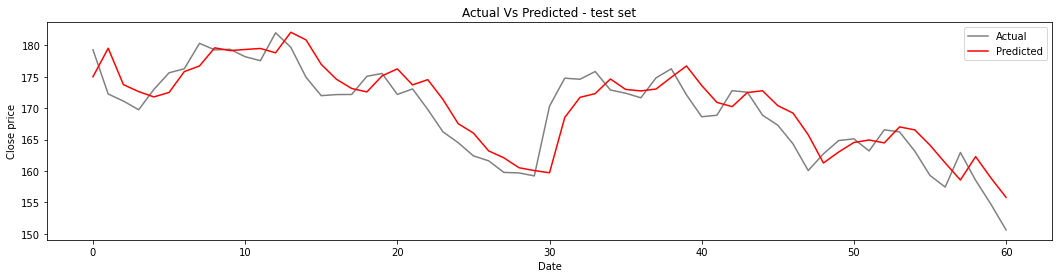

In [ ]:
# Visualising the results
plt.figure(figsize=(18,4))
plt.plot( data['Close'][train_size : train_size+test_size].values, color = 'gray', label = 'Actual')
plt.plot( predictions, color = 'red', label = 'Predicted')
plt.xticks(np.arange(0, predictions.shape[0], 10))
plt.title('Actual Vs Predicted - test set')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend()
plt.show()

## Keras [Functional API](https://keras.io/guides/functional_api/)

The Functional API allows for more complex network architectures, including multiple inputs and outputs, shared layers, etc.

In [ ]:
from keras import Model
from keras.layers import Input

In [ ]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
hidden_layer = LSTM(16, return_sequences=True, activation='relu')(input_layer)
hidden_layer = LSTM(8, activation='relu')(hidden_layer)
dense_layer = Dense(4, activation = 'relu')(hidden_layer)
output_layer = Dense(1, activation='linear')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

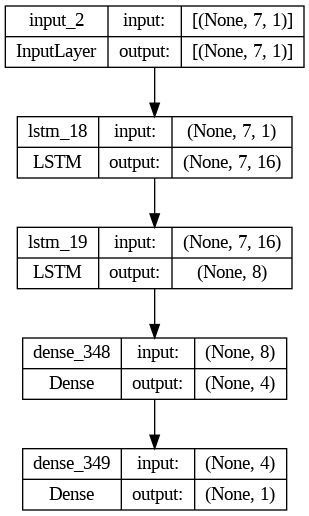

In [ ]:
model_plot = plot_model(model, show_shapes=True)
model_plot

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')
model_fit = model.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose=0)
predictions = model.predict(X_test)
print('RMSE: %.3f, MAE: %.3f' %(np.sqrt(mean_squared_error(y_test, predictions)) , mean_absolute_error(y_test, predictions)))

# predictions = sc.inverse_transform(predictions)

2/2 [==============================] - 0s 8ms/step
RMSE: 0.192, MAE: 0.174


## [Pytorch](https://pytorch.org/docs/stable/index.html) implementation

In [ ]:
%%capture
!pip install torch

Epoch [1/100], Loss: 0.2367
Epoch [2/100], Loss: 0.2289
Epoch [3/100], Loss: 0.2212
Epoch [4/100], Loss: 0.2136
Epoch [5/100], Loss: 0.2060
Epoch [6/100], Loss: 0.1984
Epoch [7/100], Loss: 0.1908
Epoch [8/100], Loss: 0.1833
Epoch [9/100], Loss: 0.1758
Epoch [10/100], Loss: 0.1685
Epoch [11/100], Loss: 0.1614
Epoch [12/100], Loss: 0.1548
Epoch [13/100], Loss: 0.1487
Epoch [14/100], Loss: 0.1428
Epoch [15/100], Loss: 0.1370
Epoch [16/100], Loss: 0.1313
Epoch [17/100], Loss: 0.1256
Epoch [18/100], Loss: 0.1200
Epoch [19/100], Loss: 0.1145
Epoch [20/100], Loss: 0.1090
Epoch [21/100], Loss: 0.1036
Epoch [22/100], Loss: 0.0981
Epoch [23/100], Loss: 0.0927
Epoch [24/100], Loss: 0.0873
Epoch [25/100], Loss: 0.0820
Epoch [26/100], Loss: 0.0768
Epoch [27/100], Loss: 0.0716
Epoch [28/100], Loss: 0.0665
Epoch [29/100], Loss: 0.0616
Epoch [30/100], Loss: 0.0568
Epoch [31/100], Loss: 0.0522
Epoch [32/100], Loss: 0.0478
Epoch [33/100], Loss: 0.0435
Epoch [34/100], Loss: 0.0395
Epoch [35/100], Loss: 0

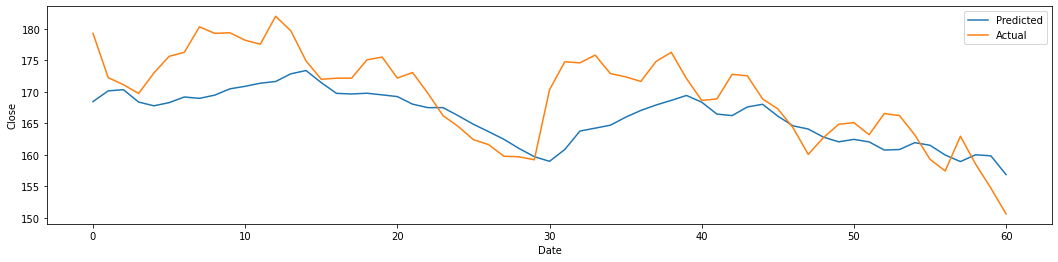

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model architecture
input_dim = X_train.shape[2]
hidden_dim = 32
num_layers = 2
output_dim = y_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_dim*h, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim)
)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
        # By converting our NumPy arrays to PyTorch tensors,
        # we can take advantage of PyTorch's automatic differentiation capabilities and perform gradient-based optimization on the neural network
    inputs = torch.from_numpy(X_train.reshape(-1, input_dim*h)).float()
    labels = torch.from_numpy(y_train).float()
    optimizer.zero_grad() # in each iteration of the training loop, we don't want the gradients to accumulate from previous iterations.
                          # Therefore, before computing the gradients for the current iteration, we need to zero out the gradients from the previous iteration.
                          # This helps prevent the gradients from exploding or vanishing and can lead to more stable training of the neural network.
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()   # calculates the gradients of the loss function with respect to the model parameters
    optimizer.step()  # updates the model parameters by taking a step in the opposite direction of the gradients
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

# Evaluate the model
model.eval()
with torch.no_grad():  # we use torch.no_grad() during model evaluation to calculate the test loss and make predictions on the test set without computing gradients to speed up the computation and save memory
    inputs = torch.from_numpy(X_test.reshape(-1, input_dim*h)).float()
    labels = torch.from_numpy(y_test).float()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    print('Test Loss: {:.4f}'.format(loss.item()))

# Inverse transform the predicted and actual values
predicted_prices = sc.inverse_transform(outputs.numpy())
actual_prices = sc.inverse_transform(labels.numpy())

# Plot the predicted and actual prices
plt.figure(figsize=(18,4))
plt.plot(predicted_prices, label='Predicted')
plt.plot(actual_prices, label='Actual')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()